In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from fuzzywuzzy import fuzz

In [ ]:
df = pd.read_csv("./data/stayzilla_com-travel_sample.csv")
df = df.drop(['sitename','uniq_id'], axis = 1)

## 1.0 Overview

### 1.1 Sample and shape

In [ ]:
df.head(5)

In [ ]:
df.shape

The dataset is a conglomoration of text and dates; these values will need to be cleaned before any real analysis is done. There are 1207 observations and about 32 features. 

### 1.2 Split DataSet

In [ ]:
df.iloc[1137:,:].head(5)

There is a clear split in the observations in the dataset beginning at index 1139; from that point onwards, observations have a different layout and have a pattern of missing values, which will be addressed shortly. This problem definitely needs to be addressed. 

### 1.3 Missing Values

In [ ]:
df.isna().sum().sum()

There are over 8500 missing values in the dataset, meaning that said dataset is over 20% missing values. As mentioned previously, they are NOT randomly distributed. You can see this below:

In [ ]:
missings = df.isna().sum()[df.isna().sum() > 0].sort_values(ascending = False)
#missings = pd.DataFrame(missings, columns=['MissingValues']).sort_values("MissingValues", ascending=False)

plt.figure(figsize=(25,8))
plt.title("Missing Values by Feature")
sns.barplot(x = list(missings.index), y = list(missings.values))
#plt.table(cellText=missings.values, rowLabels=missings.index, colLabels=missings.columns, cellLoc='right', rowLoc='center', loc='right', bbox=[0.79, 0.69, 0.2, 0.3])

### 1.4 Misleading Values

In [ ]:
df[['additional_info', 'amenities','internet','things_to_do','things_to_note']].iloc[4:,:]

As you can see above, the internet feature should be binary, but missing values represent a large quantity (over 90%) of values. This is due to the aforementioned split. The attribute's information is displayed elsewhere, depending on the hotel in question. I have personally found it in all of the above features. I personally recommend that we split these attributes into their own specific binary features. (Kind of a one hot encoding scenario). This is especially the case for the has/has no internet case mentioned previously; we add a new feature called Wifi, check each observation for a positive identifier, and use that logic to create the new var. 

## 2.0 Cleaning this Mess

### 2.1. Fixing the Pricing, Rating, and Date Problems

In [ ]:
df[['check_in_date','room_price','hotel_star_rating']]

All of these features are strings when they should be, respectively, dates and integers. The ratings feature does not seem to have many real values (i.e. not Nan or 0); although said feature would be helpful in theory, it only having these values would make it worthless.

### 2.1.1  Room Price

In [ ]:
# Room price - convert to integer after dropping string segments
df['room_price'] = pd.to_numeric(df['room_price'].str.replace('p.*', '', regex = True))

Aside from transforming the feature from a string into a float value, we need to look at its distribution:

In [ ]:
plt.figure(figsize = (8,8))
sns.histplot(data = df, x = "room_price")
plt.title("Room Price Distribution");

Well, that is not a normal distribution. There also seems to be a couple of outliers that are causing problems. Let's take a look.

In [ ]:
print('Top Down', '\n', df['room_price'].sort_values(ascending = False).head(20), '\n')
print('Bottom Up', '\n', df['room_price'].sort_values().head(5))
df = df.drop(index = [437,331,537,696, 96])

# reset index and remove prior one
df.reset_index(inplace = True, drop = True)

Personally, I think we have five outliers here. The first two are obvious (those above 70000), but the values above 30000 are still well outside of the distribution's mass. There is also an outlier on the lower end, the hotel that charges 2 per night. After removing the outliers, we will fit the room price attribute to a Gaussian distribution by performing a log transformation.

In [ ]:
df['room_price_as_pct_of_income'] = df['room_price_as_pct_of_income'].transform(np.log)
df['room_price'] = df['room_price'].transform(np.log)

plt.figure(figsize = (8,8))
sns.histplot(data = df, x = 'room_price_as_pct_of_income')
plt.title("Room Price Distribution (log)");

Beautiful

### 2.1.2  Median Income By State & Room Price as Pct of Median Income

Next up, I want to create a new feature, room price as percentage of median income by state. 

### 2.1.3 Datetime

In [ ]:
## Convert feature to datetime
temp = pd.to_datetime(df['check_in_date'])

## Retrieve year and month from the datetime feature; allow them their own attribute
df['check_year'] = pd.DatetimeIndex(temp).year
df['check_month'] = pd.DatetimeIndex(temp).month

## drop overlapping features
df = df.drop(['check_in_date','check_out_date'], axis = 1)

### 2.1.4  Ratings

In [ ]:
# Ratings - find if it can be saved

print(df['hotel_star_rating'].fillna(-1).value_counts())
df = df.drop('hotel_star_rating', axis = 1)

It cannot; more than 1100 of the values are missing (-1), and fifty more have zeroes as their rating, which may also be standins for missing at this point. Unless we retrieve more information, this feature is useless

### 2.2  Fixing the Country and Occupancy Features

In [ ]:
df[['occupancy','country']]

These two features suffer from slightly different problems. Country has one value; it is known based on the metadata, so we will fill it in. I wanted to keep the feature because it may be what allows us to differentiate this set from the one Anh finds. Occupancy is a string, which should be a numeric value. I'll place each value in their own attribute, which we could then easily combine later if needed.

In [ ]:
## Convert all values in country feature to 'India'
df['country'] = 'India'

# split occupancy into occupancy for adults and children
df['occupancy'] = df['occupancy'].str.replace('\D', ' ', regex = True).str.split()
df['occupancy_adult'] = pd.to_numeric(df['occupancy'][0][0])
df['occupancy_child'] = pd.to_numeric(df['occupancy'][0][1])
df = df.drop('occupancy', axis = 1)

df[['occupancy_adult','occupancy_child']]

### 2.3 Finding Common Values Across the Four Features Shown Above

In [ ]:
### Fill missing values and clean the strings

df['things_to_do'] = df['things_to_do'].fillna(' 0 ')
df['things_to_do'] = df['things_to_do'].str.replace('|', '').str.replace('/',' ').str.lower()
df['amenities'] = df['amenities'].fillna(' 0 ')
df['amenities'] = df['amenities'].str.replace('|', ' ').str.replace('&', '').str.replace('/', ' ').str.lower()

df['service_value'] = df['service_value'].fillna(' 0 ')
df['service_value'] = df['service_value'].str.replace('|', ' ').str.lower()

## Moving things of note info where they should be for records 1139 to the end
cut = df.iloc[1134:,0]
df.iloc[1134:]['things_to_note'] = cut
df.iloc[1134:,0] = float('NAN')
df['things_to_note'] = df['things_to_note'].fillna(' 0 ')
df['things_to_note'] = df['things_to_note'].str.replace('[^a-zA-Z]', ' ', regex = True).str.replace('Kindly Note:*', "", regex = True).str.lower()

### Create a concat feature that consists of concatenated strings from prior four features
df['concat'] = df['amenities'] + df['things_to_do'] + df['things_to_note'] + df['service_value']
df['concat'] = df['concat'].str.split()

I removed any separators and miscellaneous signs from each Series. Additionally, I moved the observations from the second grouping of data (records 1134-1206) under the 'additional_info' to the 'things_to_note' feature. This is due to the similar phrases used by both such as 'All taxes' and 'Complimentary Wifi'. I also removed everything occurring after 'Kindly Note:' in the 'things_to_note' attribute; everything ocurring after that phrase is too granular (as in its specific to each individual hotel). Lastly I filled in NaN values with zeroes as strings.

In [ ]:
unique_vals = []
for value in df['amenities'].str.split():
    if value == value:
        for word in value:
            unique_vals.append(word)
unique_vals = list(set(unique_vals))
unique_vals

These are the unique values for the 'amenities' feature. There is not that much variety in the number of words used, so, if we can match those keywords with those used in the other features, we have a way forward.

In [ ]:
unique_vals = []
for value in df['things_to_do'].str.split():
    if value == value:
        for word in value:
            unique_vals.append(word)
unique_vals = list(set(unique_vals))
unique_vals

Perfect! This feature does not have too many keywords, and they match those of 'amenities'.

In [ ]:
unique_vals = []
for value in df['service_value'].str.split():
    if value == value:
        for word in value:
            unique_vals.append(word)
unique_vals = list(set(unique_vals))
unique_vals

No problems here

In [ ]:
unique_vals = []
for value in df['things_to_note'].str.split():
    if value == value:
        for word in value:
            unique_vals.append(word)
unique_vals = list(set(unique_vals))
unique_vals.sort()
len(unique_vals)

So this last list is a bit ridiculous because each of the sections are written by each specific hotelier rather than using keywords. Even after condensing much of the work with regular expressions (down from about 1200), misspellings and the like make exact matches an exercise in frustration. The new plan is to use fuzzy string matching to do the work for me. 

### 2.3 Convert Keywords to Features

In [ ]:
pot_features = ['restaurant', 'pool', 'health', 'bar', 'wifi','laundry','elevator','credit','business','newspaper','gym','veg','parking','pickup','taxes','breakfast']

# for each keyword(unique) in the potential features list, create a list of zeroes, search the new 'concat' attribute for the keyword, and, if they find a match on observation i, convert col[i] to true
# then transform the list into a series, which is then added to the dataset before the next loop iteration begins
for unique in pot_features:
    col = [0]*len(df)
    i = 0
    for string in df['concat']:
        for word in string:
            if fuzz.ratio(unique, word) >= 80:
                col[i] = 1
        i += 1
    df[unique] = pd.Series(col, name=unique)

## Drop previous features
df = df.drop(['amenities','things_to_do','things_to_note','concat','service_value'], axis = 1)

In [ ]:
df[pot_features].sum().sort_values()

My plan here is to create a new feature for each keyword to replace the jumbled mess that the prior attributes left us with. There is occasional overlap, like with internet and wifi, but we can merge them afterwards. 

### 2.4 Merging Overlapping Features and Renaming Vague Ones

In [ ]:
df = df.rename(columns= {'veg': 'vergetables_only', 'taxes':'all_taxes', 'pickup':'pickup_and_drop', 'business':'business_center'})

In [ ]:
## internet
df['internet'] = np.where(((df['internet'] != df['internet']) | (df['internet'] == 'Internet not present')), 0, 1)
df['wifi'] = np.where(((df['internet'] == 1) | (df['wifi'] == 1)), 1, 0)
df = df.drop('internet', axis = 1)

After merging 'wifi' and 'internet', we are left with these features and these values. What we need to decide on now is what features are prevalent enough to be kept, and which ones are unrealistic. This, of course should be done with as little bias as possible, but there is a clear concern that some hotels can claim some aspect of its services are a selling point while others who still have taht service (elevator for example) don't mention it. We could make the argument/assumption that these features designate what is marketed towards customers rather than what is actually there. 

A couple of the suggested changes: combine restaurant and breakfast because, presumedly, the breakfast is served at the hotel's rough equivalent to a restaurant. Maybe also merge gym and health center. I'd also recommend dropping all features with less than 50 positive values. 

In [ ]:
## eating
df['restaurant'] = np.where(((df['restaurant'] == 1) | (df['breakfast'] == 1)), 1, 0)
df['gym'] = np.where(((df['gym'] == 1) | (df['health'] == 1)), 1, 0)
df = df.drop(['breakfast','health','business_center','credit'], axis = 1)

There are also a lot of features in this dataset that do not seem to be relevant towards our stated goals. I believe we should drop them (shown below), but a second/group opinion would be best.

In [ ]:
df = df.drop(['crawl_date','description','highlight_value','image_count','image_urls','property_id','qts','pageurl', 'query_time_stamp','similar_hotel','property_address','additional_info','search_term','landmark'], axis = 1)

## 3.0. So What Do We Have?

### 3.1: Geographic Location

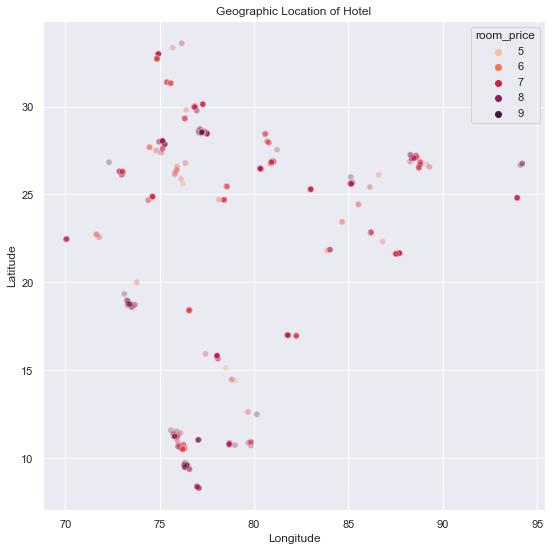

In [66]:
sns.set_theme()
cmap = sns.color_palette("rocket_r", as_cmap=True)
plt.figure(figsize=(9,9))
sns.scatterplot(df['longitude'], df['latitude'], hue = df['room_price'], alpha = 0.3, palette = cmap)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographic Location of Hotel");

We can see the hotels spread across India and multiple clusters, especially near Mumbai and New Delhi. 

### 3.2: Correlation Coefficient

## 4.0 Pipeline

In [ ]:
## Numerical Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('standard', StandardScaler())
])

## Full Pipeline
from sklearn.compose import ColumnTransformer

tempdf = df.drop(['city','country','property_name','room_price','room_price_as_pct_of_income','check_year','check_month'])

categorical_attributes = ['property_type']
numerical_attributes = ['occupancy_adult','occupancy_child','latitude','longitude']

full_pipeline = ColumnTransformer([
    ('cats', OneHotEncoder(), categorical_attributes),
    ('nums', num_pipeline, numerical_attributes),
    remainder = 'passthrough'
])

tempdf = full_pipeline.fit_transform(tempdf)

# TODO
1. Add in features (2.1.2): state, median state income, divide room price by median income (or we simply use the national median income)
2. fill in NA values in room price by finding the median per state (maybe city)
3. Find the correlation coefficient and p-values for numerical features (3.2)